In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report



import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2,l1
# tf.compat.v1.disable_eager_execution()
import warnings



# Train Data

In [2]:
train_df=pd.read_csv("data/clean_data/train_clean.csv").drop('Unnamed: 0',axis=1)

In [3]:
train_df.head()

,rec_id,text,sentiment,rating,clean_text
0,4715,For a movie that gets no respect there sure ar...,pos,9,movie get respect sure lot memorable quote lis...
1,12390,Bizarre horror movie filled with famous faces ...,pos,8,bizarre horror movie fill famous face steal cr...
2,8329,"A solid, if unremarkable film. Matthau, as Ein...",pos,7,solid remarkable film matthau einstein wonderf...
3,9063,It's a strange feeling to sit alone in a theat...,pos,8,strange feeling sit alone theater occupy paren...
4,3092,"You probably all already know this by now, but...",pos,10,probably already know additional episode never...


In [4]:
# train_df.columns
# df_pos = train_df[train_df['sentiment'] == 'pos']
# df_neg = train_df[train_df['sentiment'] == 'neg']
# num_samples = min(len(df_pos), len(df_neg))

# df_pos = df_pos.sample(frac=1).reset_index(drop=True)
# df_neg = df_neg.sample(frac=1).reset_index(drop=True)

# reshuffled_df = pd.DataFrame(columns=['rec_id', 'text', 'sentiment', 'rating', 'clean_text'])

# for i in range(num_samples):
#     reshuffled_df = pd.concat([reshuffled_df, pd.DataFrame([df_pos.iloc[i]])])
#     reshuffled_df = pd.concat([reshuffled_df, pd.DataFrame([df_neg.iloc[i]])])

# reshuffled_df = reshuffled_df.reset_index(drop=True)

# train_df=reshuffled_df

In [5]:
train_df['sentiment'].value_counts()

sentiment
pos    12500
neg    12500
Name: count, dtype: int64

In [6]:
train_df['rating'].value_counts()

rating
1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: count, dtype: int64

# Choose num_words in tokenizer and maxlen of padded_sequences

### on raw data

In [7]:
# Seeing unique words in raw data just to understand how many words are removed due to stop words & lemmatisation
texts = train_df['text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [8]:
vocab_size = len(tokenizer.word_index)

In [9]:
print(f"Total unique words in raw dataset: {vocab_size}")

Total unique words in raw dataset: 88582


### on clean data

In [10]:
texts = train_df['clean_text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [11]:
vocab_size = len(tokenizer.word_index)

In [12]:
print(f"Total unique words in clean dataset: {vocab_size}")

Total unique words in clean dataset: 41567


In [13]:
word_counts = tokenizer.word_counts
word_count_list = list(word_counts.values())

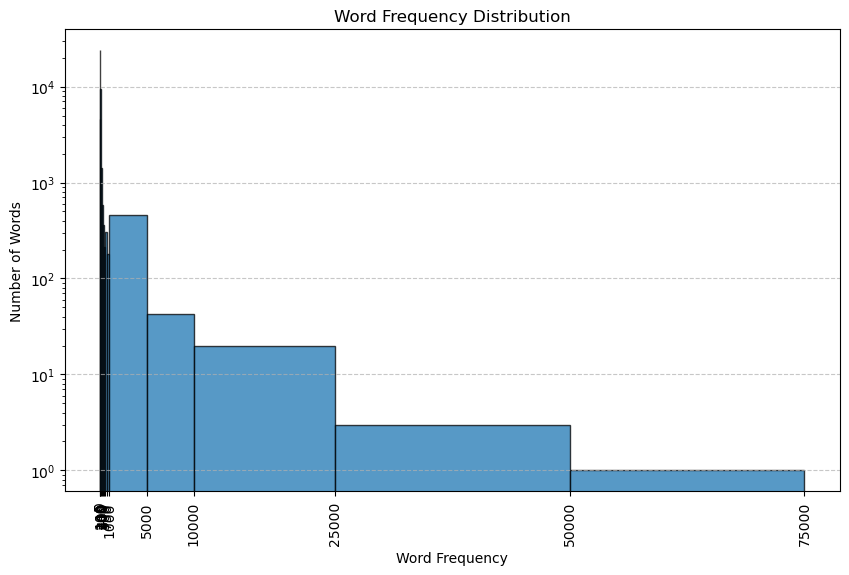

Bin Edges: [0.0e+00 5.0e+00 1.0e+01 1.0e+02 2.0e+02 3.0e+02 4.0e+02 5.0e+02 7.5e+02
 1.0e+03 5.0e+03 1.0e+04 2.5e+04 5.0e+04 7.5e+04]
Values: [2.3896e+04 4.5820e+03 9.4880e+03 1.4290e+03 5.8500e+02 3.6400e+02
 2.1400e+02 3.0800e+02 1.7800e+02 4.5600e+02 4.3000e+01 2.0000e+01
 3.0000e+00 1.0000e+00]


In [14]:
plt.figure(figsize=(10, 6))
hist, bin_edges, _ = plt.hist(word_count_list,bins=[0,5,10,100,200,300,400,500,750,1000,5000,10000,25000,50000,75000], edgecolor='k', alpha=0.75)
plt.xticks([0,5,10,100,200,300,400,500,750,1000,5000,10000,25000,50000,75000],rotation=90)
plt.yscale('log')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Bin Edges:", bin_edges)
print("Values:", hist)

In [15]:
pd.DataFrame(word_count_list).describe()

,0
count,41567.000000
mean,72.410229
std,674.744562
min,1.000000
25%,1.000000
50%,3.000000
75%,16.000000
max,66008.000000


In [16]:
# so if we consider num_words to be around 20K; to get all the words which have frequency greater than 5.

In [17]:
sequence_lengths = [len(text.split()) for text in texts]

In [18]:
pd.DataFrame(sequence_lengths).describe()

,0
count,25000.00000
mean,120.39504
std,90.83617
min,4.00000
25%,64.00000
50%,89.00000
75%,147.00000
max,1403.00000


<Axes: ylabel='Density'>

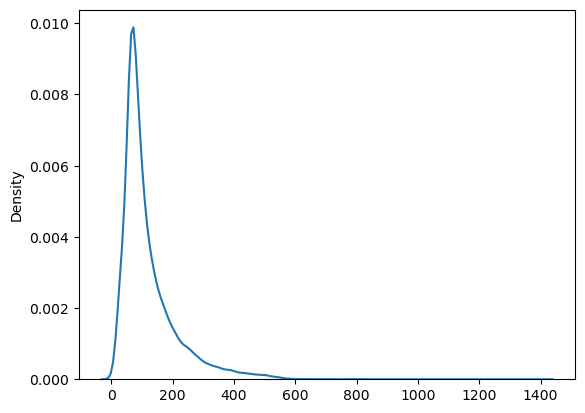

In [19]:
sns.kdeplot(sequence_lengths)

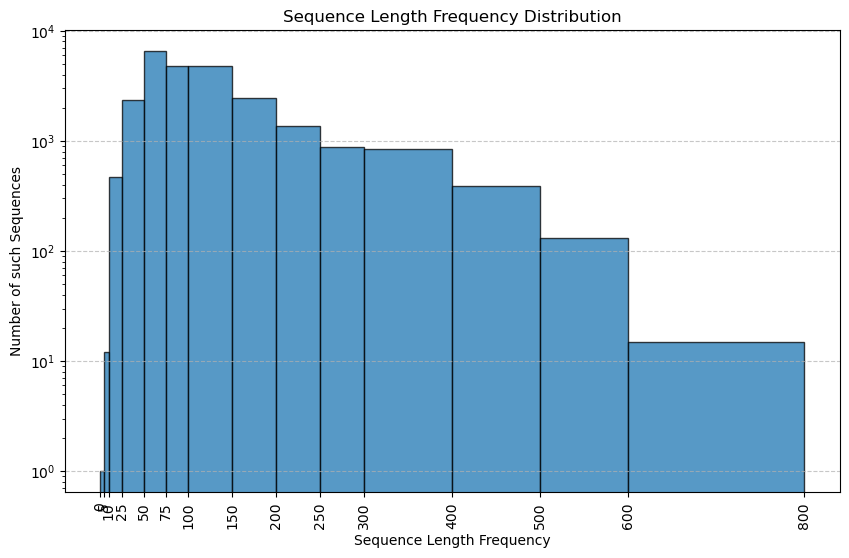

Bin Edges: [  0.   5.  10.  25.  50.  75. 100. 150. 200. 250. 300. 400. 500. 600.
 800.]
Values: [1.000e+00 1.200e+01 4.730e+02 2.339e+03 6.543e+03 4.833e+03 4.743e+03
 2.442e+03 1.362e+03 8.720e+02 8.410e+02 3.880e+02 1.310e+02 1.500e+01]


In [20]:
plt.figure(figsize=(10, 6))
hist, bin_edges, _ = plt.hist(sequence_lengths,bins=[0,5,10,25,50,75,100,150,200,250,300,400,500,600,800], edgecolor='k', alpha=0.75)
plt.xticks([0,5,10,25,50,75,100,150,200,250,300,400,500,600,800],rotation=90)
plt.yscale('log')
plt.title('Sequence Length Frequency Distribution')
plt.xlabel('Sequence Length Frequency')
plt.ylabel('Number of such Sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Bin Edges:", bin_edges)
print("Values:", hist)

In [21]:
# As there are only ~5K with sentences with length greater than 250; 
# we can select with maxlen between of 0 and 250;

# Training and Testing

In [22]:
'''Hyper parameters here are
1. Tokenizer(num_words)
2. max_len of sequences for padding and truncating
3. Model Architecture
4. optimizer
5. Learning rate
6. Batch Size

'''

'Hyper parameters here are\n1. Tokenizer(num_words)\n2. max_len of sequences for padding and truncating\n3. Model Architecture\n4. optimizer\n5. Learning rate\n6. Batch Size\n\n'

In [23]:
test_df=pd.read_csv("data/clean_data/test_clean.csv")

In [24]:
class custom_RNN:
    def __init__(self,train_df,test_df,tokenizer_func,max_len,optimizer,num_words=5000,batch_size=32):
        self.train_df=train_df
        self.test_df=test_df
        self.tokenizer_func=tokenizer_func
        self.num_words=num_words
        self.max_len=max_len
        self.optimizer=optimizer
        self.batch_size=batch_size
    
    def get_sequences(self,data,is_train=False):
        if(is_train):
            tokenizer = self.tokenizer_func(num_words=self.num_words, oov_token='<OOV>')
            tokenizer.fit_on_texts(data)
            self.tokenizer=tokenizer
        sequences = self.tokenizer.texts_to_sequences(data)
        padded_sequences = np.array(pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post'))
        
        return padded_sequences
    
    
    def train(self,model_type,epochs=10,is_raw=False):
        
        if(model_type=='s'):
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=128, input_length=self.max_len),
            tf.keras.layers.SimpleRNN(64, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='m'):
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=384, input_length=self.max_len),
            tf.keras.layers.SimpleRNN(256, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='l'):
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=768, input_length=self.max_len),
            tf.keras.layers.SimpleRNN(384, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
            
        ])
            
         
        
        else:
            print("please enter a valid model type s/m/l; choose one")
            return
        
        self.is_raw=is_raw
        
        if(is_raw):
            train_sequences=self.get_sequences(self.train_df['text'].tolist(),is_train=True)
        else:
            train_sequences=self.get_sequences(self.train_df['clean_text'].tolist(),is_train=True)
        
            
        
        y_train=np.array(self.train_df['sentiment'].map({'pos':1,'neg':0}).tolist())
        
        
        combined_data = list(zip(train_sequences, y_train))
        
        np.random.seed(12)
        
        np.random.shuffle(combined_data)
        
        train_sequences, y_train = zip(*combined_data)
        
        train_sequences=np.array(train_sequences)
        
        y_train=np.array(y_train)
        
        
        num_validation_samples = int(0.20 * len(train_sequences))
        
        x_train = train_sequences[:-num_validation_samples]
        y_train = y_train[:-num_validation_samples]
        x_val = train_sequences[-num_validation_samples:]
        y_val = y_train[-num_validation_samples:]
        
        
        early_stopping_acc= EarlyStopping(monitor='val_accuracy', patience=2, verbose=1,start_from_epoch=5,restore_best_weights=True)
        
        early_stopping_loss= EarlyStopping(monitor='val_loss', patience=2, verbose=1,start_from_epoch=5,restore_best_weights=True)
        
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        history=model.fit(x_train, y_train, epochs=epochs, batch_size=self.batch_size, validation_data=(x_val, y_val),shuffle=False,callbacks=[early_stopping_acc,early_stopping_loss])
        
        
        
        if early_stopping_acc.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_acc.stopped_epoch + 1}, based on the validation accuracy.')
        if early_stopping_loss.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_loss.stopped_epoch + 1}, based on the validation loss.')
        
        self.model=model
        
        self.training_accuracy = history.history['accuracy']
        self.validation_accuracy = history.history['val_accuracy']
        
        self.training_loss = history.history['loss']
        self.validation_loss = history.history['val_loss']
        
        
        
        model.save('data/LSTM_models/model_type_'+str(model_type)+'_'+'epochs_'+
              str(epochs)+'_'+str(self.num_words)+'_'+str(self.max_len)+'_'+str('adam')+'_'+str(is_raw))
        
        
        
    def evaluate(self):
        
        if(self.is_raw):
            test_sequences=self.get_sequences(self.test_df['text'].tolist(),is_train=False)
        else:
            test_sequences=self.get_sequences(self.test_df['clean_text'].tolist(),is_train=False)
        
        y_test=np.array(self.test_df['sentiment'].map({'pos':1,'neg':0}).tolist())
        
        predictions = self.model.predict(test_sequences)
        
        binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]
        
        accuracy_rnn = accuracy_score(y_test, binary_predictions)
        
        print("Accuracy (RNN):", accuracy_rnn)
        
        
        confusion_matrix_rnn = confusion_matrix(y_test, binary_predictions)
        
        print("Confusion Matrix (RNN):\n", confusion_matrix_rnn)
        
        
        classification_report_rnn = classification_report(y_test, binary_predictions)
        
        print("Classification Report (RNN):\n", classification_report_rnn)
        
        
        
        
        

# smaller Model

In [25]:
#choose hyper parameters with less num_words and max_len

In [26]:
# num_words=500,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=500,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Epoch 1/100


2023-11-10 03:23:37.066947: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40/40 [==============================] - 8s 183ms/step - loss: 0.5341 - accuracy: 0.7307 - val_loss: 0.7094 - val_accuracy: 0.4928
Epoch 2/100
40/40 [==============================] - 8s 207ms/step - loss: 0.4149 - accuracy: 0.8214 - val_loss: 0.7110 - val_accuracy: 0.4938
Epoch 3/100
40/40 [==============================] - 7s 182ms/step - loss: 0.3972 - accuracy: 0.8289 - val_loss: 0.7232 - val_accuracy: 0.4872
Epoch 4/100
40/40 [==============================] - 8s 209ms/step - loss: 0.3917 - accuracy: 0.8299 - val_loss: 0.7928 - val_accuracy: 0.4978
Epoch 5/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3901 - accuracy: 0.8336 - val_loss: 0.7943 - val_accuracy: 0.4962
Epoch 6/100
40/40 [==============================] - 7s 166ms/step - loss: 0.4364 - accuracy: 0.8126 - val_loss: 1.4427 - val_accuracy: 0.5026
Epoch 7/100
40/40 [==============================] - 6s 159ms/step - loss: 0.4507 - accuracy: 0.7998 - val_loss: 1.4966 - val_accuracy: 0.4970
Epoch 8/100

2023-11-10 03:24:35.288620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-11-10 03:24:35.293238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-11-10 03:24:35.444444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,128]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_500_150_adam_False/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 64)           12352     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                    

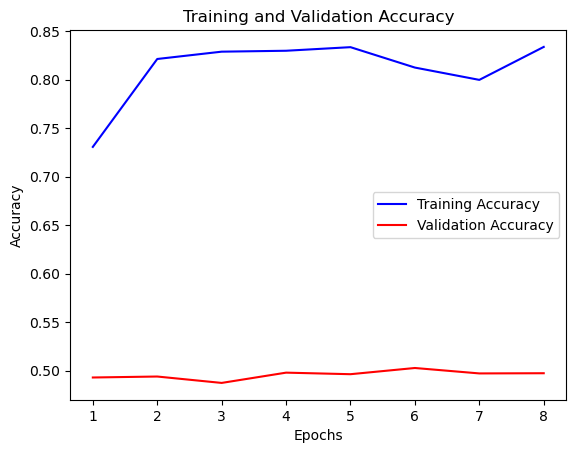

In [27]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

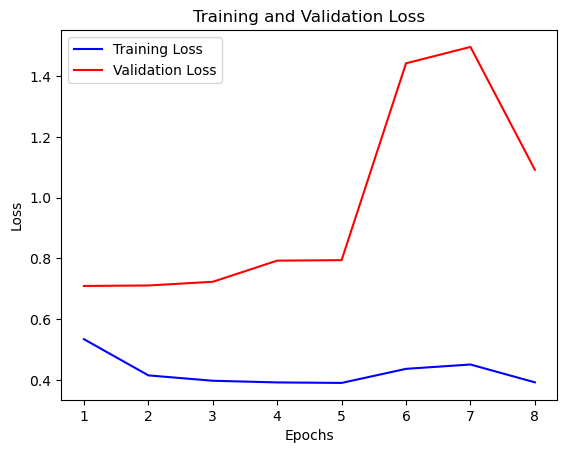

In [28]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
# num_words=750,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=750,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 7s 169ms/step - loss: 0.5338 - accuracy: 0.7288 - val_loss: 0.7036 - val_accuracy: 0.5012
Epoch 2/100
40/40 [==============================] - 6s 163ms/step - loss: 0.3761 - accuracy: 0.8382 - val_loss: 0.7028 - val_accuracy: 0.4992
Epoch 3/100
40/40 [==============================] - 7s 167ms/step - loss: 0.3558 - accuracy: 0.8485 - val_loss: 0.7059 - val_accuracy: 0.4940
Epoch 4/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3500 - accuracy: 0.8508 - val_loss: 0.7148 - val_accuracy: 0.4894
Epoch 5/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3376 - accuracy: 0.8561 - val_loss: 0.7246 - val_accuracy: 0.4916
Epoch 6/100
40/40 [==============================] - 7s 180ms/step - loss: 0.3327 - accuracy: 0.8576 - val_loss: 0.7450 - val_accuracy: 0.4894
Epoch 7/100
40/40 [==============================] - 7s 186ms/step - loss: 0.3303 - accuracy: 0.8597 - val_loss: 0.7675 - val_accuracy: 0.4908

2023-11-10 03:25:40.962714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-11-10 03:25:40.967452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-11-10 03:25:41.116213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,128]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_750_150_adam_False/assets
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          96000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 64)           12352     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                  

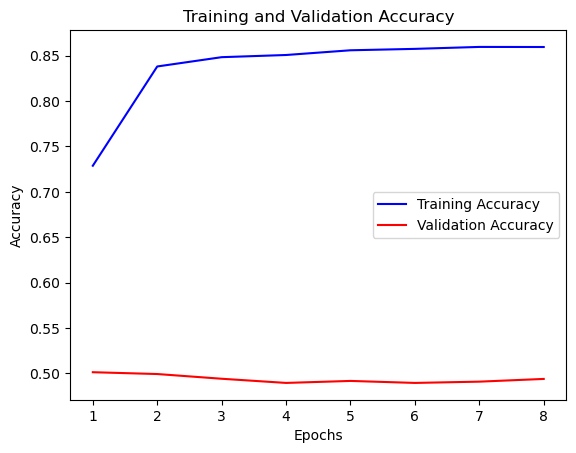

In [30]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

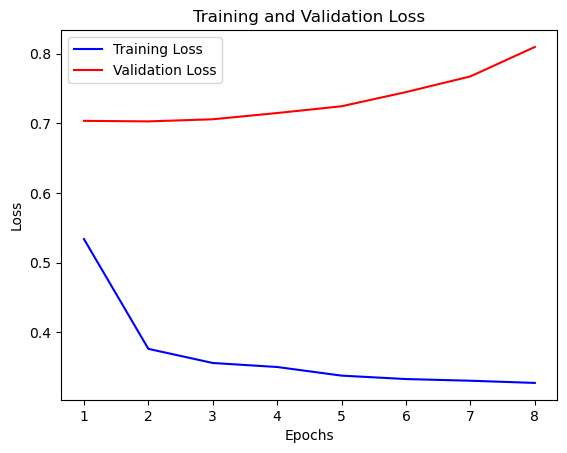

In [31]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
# num_words=1000,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=1000,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 6s 143ms/step - loss: 0.5013 - accuracy: 0.7528 - val_loss: 0.6998 - val_accuracy: 0.4932
Epoch 2/100
40/40 [==============================] - 6s 156ms/step - loss: 0.3593 - accuracy: 0.8452 - val_loss: 0.7076 - val_accuracy: 0.4968
Epoch 3/100
40/40 [==============================] - 7s 182ms/step - loss: 0.3445 - accuracy: 0.8539 - val_loss: 0.7157 - val_accuracy: 0.4962
Epoch 4/100
40/40 [==============================] - 7s 169ms/step - loss: 0.3321 - accuracy: 0.8604 - val_loss: 0.7251 - val_accuracy: 0.4998
Epoch 5/100
40/40 [==============================] - 7s 171ms/step - loss: 0.3251 - accuracy: 0.8600 - val_loss: 0.7395 - val_accuracy: 0.4952
Epoch 6/100
40/40 [==============================] - 7s 171ms/step - loss: 0.3185 - accuracy: 0.8624 - val_loss: 0.7568 - val_accuracy: 0.4962
Epoch 7/100
40/40 [==============================] - 7s 163ms/step - loss: 0.3156 - accuracy: 0.8633 - val_loss: 0.7893 - val_accuracy: 0.4980

2023-11-10 03:26:44.094252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-11-10 03:26:44.098569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-11-10 03:26:44.256564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,128]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_1000_150_adam_False/assets
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 128)          128000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 150, 64)           12352     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                 

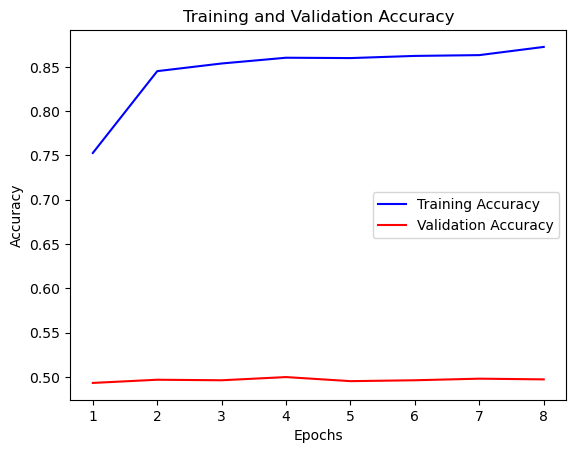

In [33]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

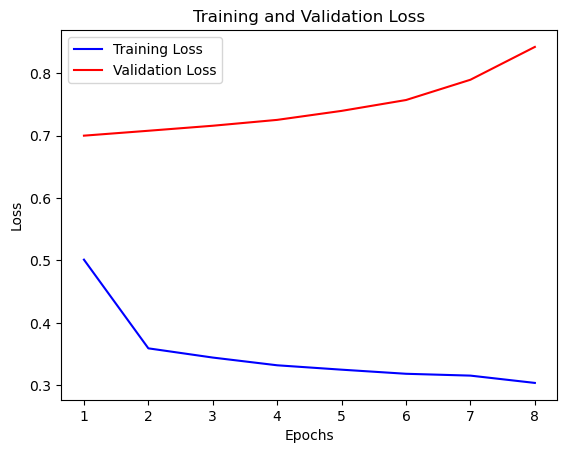

In [34]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
# num_words=2500,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=2500,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 21s 510ms/step - loss: 0.5484 - accuracy: 0.7219 - val_loss: 0.7076 - val_accuracy: 0.4976
Epoch 2/100
40/40 [==============================] - 20s 495ms/step - loss: 0.3121 - accuracy: 0.8699 - val_loss: 0.7256 - val_accuracy: 0.4954
Epoch 3/100
40/40 [==============================] - 20s 493ms/step - loss: 0.2787 - accuracy: 0.8853 - val_loss: 0.7324 - val_accuracy: 0.4884
Epoch 4/100
40/40 [==============================] - 20s 495ms/step - loss: 0.2611 - accuracy: 0.8936 - val_loss: 0.7482 - val_accuracy: 0.4952
Epoch 5/100
40/40 [==============================] - 20s 493ms/step - loss: 0.2473 - accuracy: 0.8996 - val_loss: 0.7605 - val_accuracy: 0.4900
Epoch 6/100
40/40 [==============================] - 18s 460ms/step - loss: 0.2442 - accuracy: 0.9022 - val_loss: 0.7829 - val_accuracy: 0.5018
Epoch 7/100
40/40 [==============================] - 18s 459ms/step - loss: 0.2517 - accuracy: 0.8966 - val_loss: 0.7230 - val_accuracy:

2023-11-10 03:29:31.758134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:29:31.770265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:29:31.935415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,384]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_2500_150_adam_False/assets
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 384)          960000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 150, 256)          164096    
                                                                 
 global_average_pooling1d_3   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                 

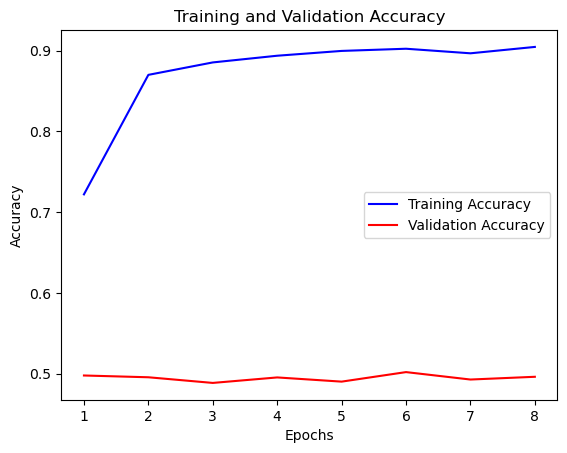

In [36]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

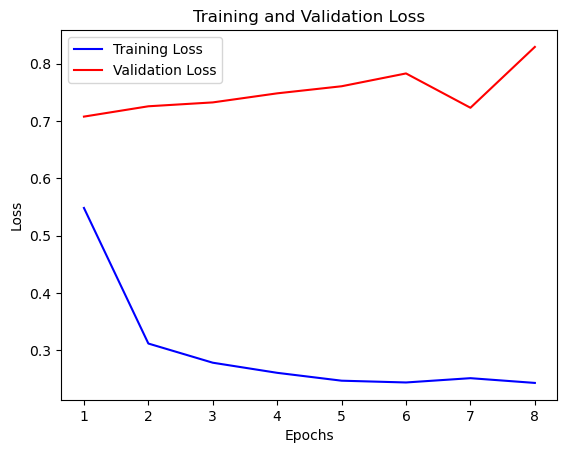

In [37]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
# num_words=5000,max_len=150, optimizer=adam,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=5000,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 22s 547ms/step - loss: 0.6975 - accuracy: 0.6247 - val_loss: 0.9965 - val_accuracy: 0.4978
Epoch 2/100
40/40 [==============================] - 20s 497ms/step - loss: 0.7519 - accuracy: 0.5461 - val_loss: 0.8208 - val_accuracy: 0.4978
Epoch 3/100
40/40 [==============================] - 19s 485ms/step - loss: 0.7219 - accuracy: 0.5525 - val_loss: 1.2951 - val_accuracy: 0.5018
Epoch 4/100
40/40 [==============================] - 20s 499ms/step - loss: 0.6620 - accuracy: 0.6308 - val_loss: 0.9092 - val_accuracy: 0.4894
Epoch 5/100
40/40 [==============================] - 20s 502ms/step - loss: 0.6746 - accuracy: 0.6107 - val_loss: 0.8858 - val_accuracy: 0.5046
Epoch 6/100
40/40 [==============================] - 21s 513ms/step - loss: 0.5361 - accuracy: 0.7534 - val_loss: 0.7612 - val_accuracy: 0.5006
Epoch 7/100
40/40 [==============================] - 19s 485ms/step - loss: 0.4062 - accuracy: 0.8273 - val_loss: 0.8772 - val_accuracy:

2023-11-10 03:32:56.831951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:32:56.838839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:32:57.064837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,384]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_False/assets
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 384)          1920000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 150, 256)          164096    
                                                                 
 global_average_pooling1d_4   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                 

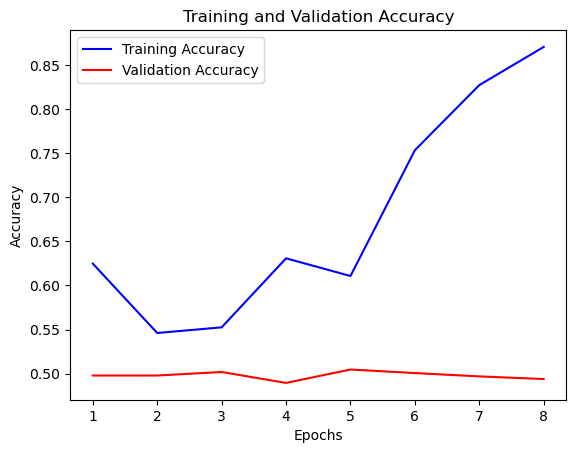

In [39]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

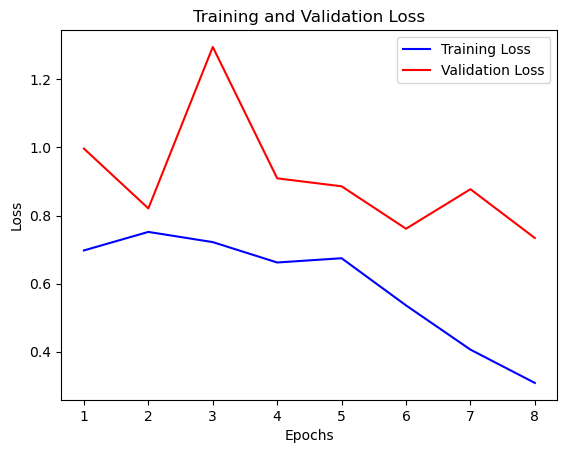

In [40]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
# num_words=5000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=5000,batch_size=512)
trainer.train('m',100,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 28s 694ms/step - loss: 0.7117 - accuracy: 0.6216 - val_loss: 1.5140 - val_accuracy: 0.4978
Epoch 2/100
40/40 [==============================] - 27s 664ms/step - loss: 0.5940 - accuracy: 0.7239 - val_loss: 0.8873 - val_accuracy: 0.5022
Epoch 3/100
40/40 [==============================] - 25s 633ms/step - loss: 0.3378 - accuracy: 0.8550 - val_loss: 0.8072 - val_accuracy: 0.5024
Epoch 4/100
40/40 [==============================] - 25s 613ms/step - loss: 0.2675 - accuracy: 0.8899 - val_loss: 0.7961 - val_accuracy: 0.4904
Epoch 5/100
40/40 [==============================] - 25s 632ms/step - loss: 0.2583 - accuracy: 0.8949 - val_loss: 0.8334 - val_accuracy: 0.4994
Epoch 6/100
40/40 [==============================] - 26s 639ms/step - loss: 0.4500 - accuracy: 0.7761 - val_loss: 1.1741 - val_accuracy: 0.4978
Epoch 7/100
40/40 [==============================] - 24s 602ms/step - loss: 0.7021 - accuracy: 0.5799 - val_loss: 1.6465 - val_accuracy:

2023-11-10 03:38:32.352799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:38:32.361650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:38:32.559148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,384]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_True/assets
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 384)          1920000   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 150, 256)          164096    
                                                                 
 global_average_pooling1d_5   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                  

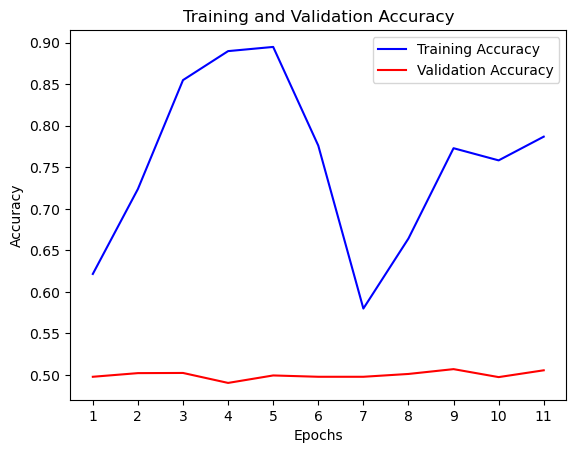

In [42]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

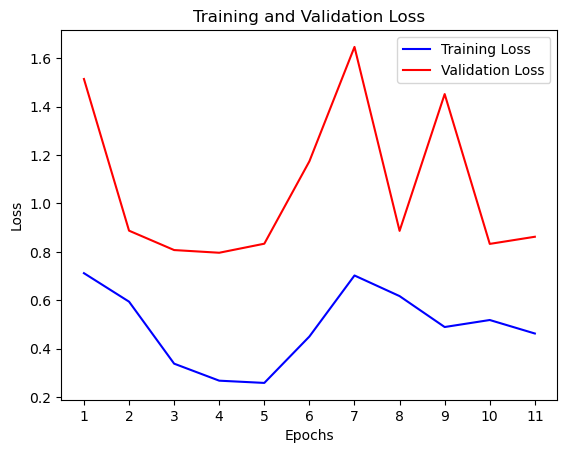

In [43]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [44]:
# num_words=7500,max_len=100, optimizer=adam,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,100,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=7500,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 18s 434ms/step - loss: 0.7322 - accuracy: 0.5455 - val_loss: 0.7416 - val_accuracy: 0.5018
Epoch 2/100
40/40 [==============================] - 18s 440ms/step - loss: 0.6631 - accuracy: 0.6381 - val_loss: 1.4691 - val_accuracy: 0.4984
Epoch 3/100
40/40 [==============================] - 18s 443ms/step - loss: 0.4431 - accuracy: 0.8055 - val_loss: 0.8445 - val_accuracy: 0.4998
Epoch 4/100
40/40 [==============================] - 17s 425ms/step - loss: 0.3704 - accuracy: 0.8381 - val_loss: 2.3790 - val_accuracy: 0.5068
Epoch 5/100
40/40 [==============================] - 18s 452ms/step - loss: 0.4307 - accuracy: 0.8079 - val_loss: 0.9442 - val_accuracy: 0.5014
Epoch 6/100
40/40 [==============================] - 17s 435ms/step - loss: 0.3284 - accuracy: 0.8602 - val_loss: 1.1983 - val_accuracy: 0.4970
Epoch 7/100
40/40 [==============================] - 17s 429ms/step - loss: 0.2846 - accuracy: 0.8826 - val_loss: 1.4291 - val_accuracy:

2023-11-10 03:41:44.535873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:41:44.541445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:41:44.973668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,384]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_7500_100_adam_False/assets
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 384)          2880000   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 100, 256)          164096    
                                                                 
 global_average_pooling1d_6   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                 

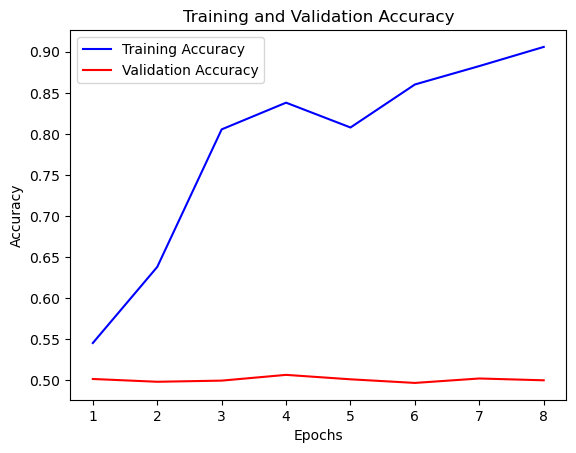

In [45]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

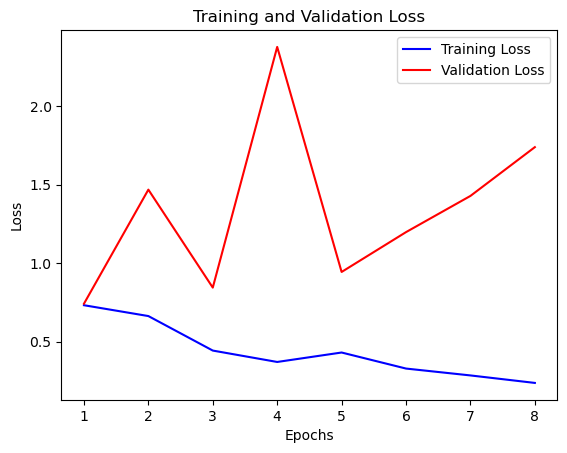

In [46]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
# num_words=7500,max_len=100, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,100,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=7500,batch_size=512)
trainer.train('m',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
40/40 [==============================] - 18s 444ms/step - loss: 0.5018 - accuracy: 0.7521 - val_loss: 0.7257 - val_accuracy: 0.4976
Epoch 2/10
40/40 [==============================] - 17s 434ms/step - loss: 0.6859 - accuracy: 0.6413 - val_loss: 0.8169 - val_accuracy: 0.4942
Epoch 3/10
40/40 [==============================] - 15s 366ms/step - loss: 0.5001 - accuracy: 0.7703 - val_loss: 2.4843 - val_accuracy: 0.4958
Epoch 4/10
40/40 [==============================] - 14s 349ms/step - loss: 0.4527 - accuracy: 0.7969 - val_loss: 1.8306 - val_accuracy: 0.4988
Epoch 5/10
40/40 [==============================] - 14s 358ms/step - loss: 0.3606 - accuracy: 0.8440 - val_loss: 2.0641 - val_accuracy: 0.4972
Epoch 6/10
40/40 [==============================] - 14s 360ms/step - loss: 0.3018 - accuracy: 0.8734 - val_loss: 2.4067 - val_accuracy: 0.4998
Epoch 7/10
40/40 [==============================] - 15s 362ms/step - loss: 0.3471 - accuracy: 0.8536 - val_loss: 0.8348 - val_accuracy: 0.4938

2023-11-10 03:44:25.833492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:44:25.838265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,384]
	 [[{{node inputs}}]]
2023-11-10 03:44:26.000414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,384]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_10_7500_100_adam_True/assets
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 384)          2880000   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100, 256)          164096    
                                                                 
 global_average_pooling1d_7   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                   

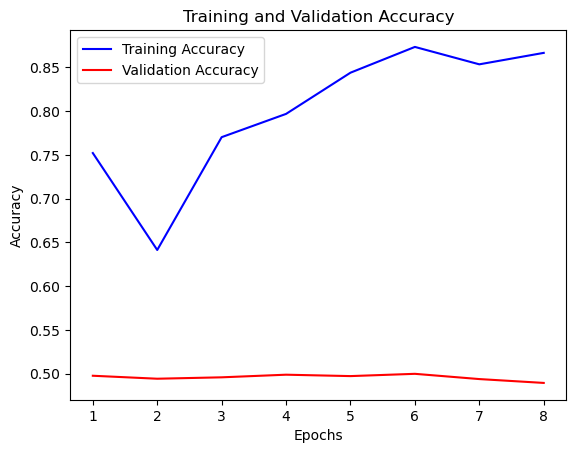

In [48]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

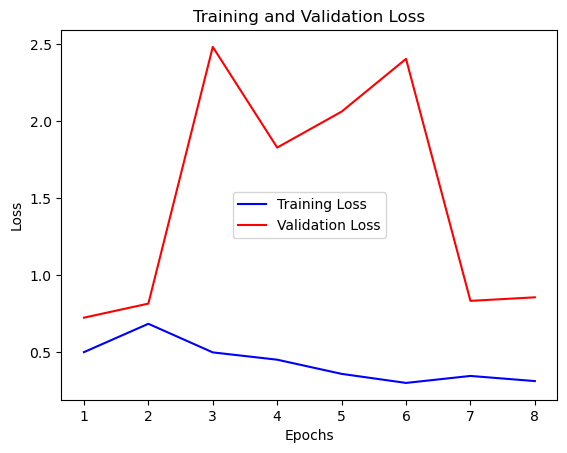

In [49]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Large Model

In [51]:
# num_words=10000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
                   ,num_words=10000,batch_size=512)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
40/40 [==============================] - 60s 1s/step - loss: 0.8347 - accuracy: 0.4974 - val_loss: 0.7504 - val_accuracy: 0.5022
Epoch 2/10
40/40 [==============================] - 55s 1s/step - loss: 0.7840 - accuracy: 0.5051 - val_loss: 0.7095 - val_accuracy: 0.4956
Epoch 3/10
40/40 [==============================] - 57s 1s/step - loss: 0.7441 - accuracy: 0.5260 - val_loss: 1.0084 - val_accuracy: 0.5000
Epoch 4/10
40/40 [==============================] - 55s 1s/step - loss: 0.7331 - accuracy: 0.5333 - val_loss: 1.0027 - val_accuracy: 0.4990
Epoch 5/10
40/40 [==============================] - 55s 1s/step - loss: 0.7240 - accuracy: 0.5210 - val_loss: 0.8484 - val_accuracy: 0.4978
Epoch 6/10
40/40 [==============================] - 55s 1s/step - loss: 0.6900 - accuracy: 0.5656 - val_loss: 0.7319 - val_accuracy: 0.4978
Epoch 7/10
40/40 [==============================] - 54s 1s/step - loss: 0.6046 - accuracy: 0.6830 - val_loss: 0.9374 - val_accuracy: 0.5010
Epoch 8/10
40/40 [==

2023-11-10 03:52:17.991078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 03:52:17.996682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 03:52:18.189119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,768]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_False/assets
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 768)          7680000   
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_8   (None, 384)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                 

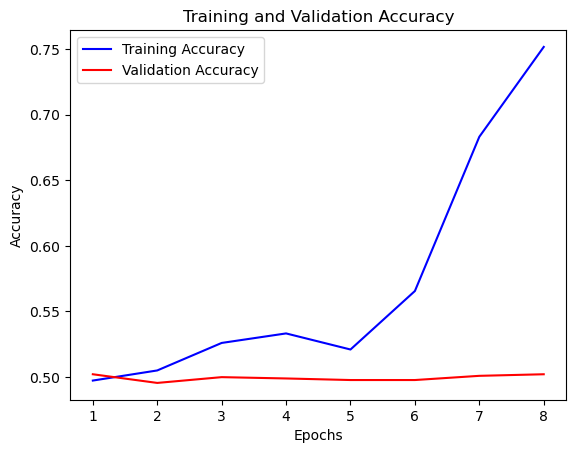

In [52]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

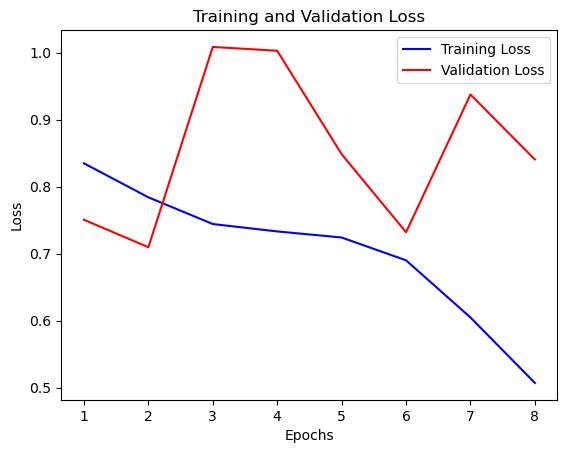

In [53]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [54]:
# num_words=10000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
                   ,num_words=10000,batch_size=512)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
40/40 [==============================] - 55s 1s/step - loss: 0.5282 - accuracy: 0.7329 - val_loss: 0.7159 - val_accuracy: 0.4974
Epoch 2/10
40/40 [==============================] - 54s 1s/step - loss: 0.2666 - accuracy: 0.8887 - val_loss: 0.7368 - val_accuracy: 0.4934
Epoch 3/10
40/40 [==============================] - 55s 1s/step - loss: 0.1943 - accuracy: 0.9269 - val_loss: 0.8765 - val_accuracy: 0.4934
Epoch 4/10
40/40 [==============================] - 49s 1s/step - loss: 0.1483 - accuracy: 0.9452 - val_loss: 1.0395 - val_accuracy: 0.4972
Epoch 5/10
40/40 [==============================] - 42s 1s/step - loss: 0.2530 - accuracy: 0.9136 - val_loss: 2.1332 - val_accuracy: 0.4978
Epoch 6/10
40/40 [==============================] - 42s 1s/step - loss: 0.7072 - accuracy: 0.6370 - val_loss: 0.7236 - val_accuracy: 0.5086
Epoch 7/10
40/40 [==============================] - 44s 1s/step - loss: 0.5935 - accuracy: 0.6908 - val_loss: 1.0284 - val_accuracy: 0.5022
Epoch 8/10
40/40 [==

2023-11-10 04:00:17.105776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:00:17.114531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:00:17.320628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,768]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_True/assets
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 768)          7680000   
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_9   (None, 384)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                  

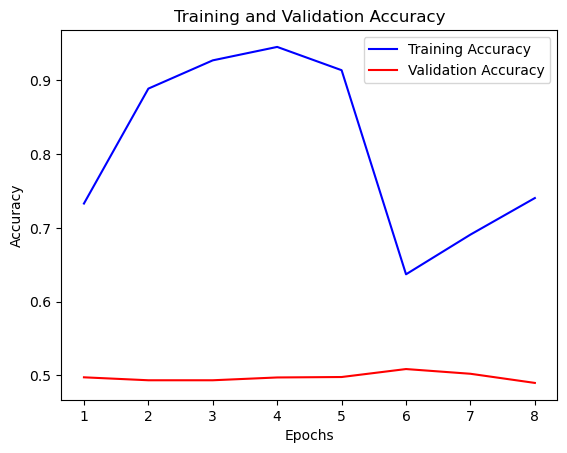

In [55]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

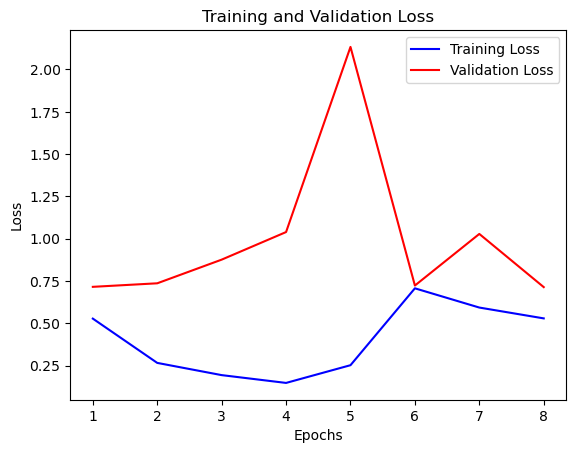

In [56]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [57]:
# num_words=20000,max_len=150, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=256)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
79/79 [==============================] - 63s 794ms/step - loss: 0.5234 - accuracy: 0.7357 - val_loss: 1.4222 - val_accuracy: 0.5022
Epoch 2/10
79/79 [==============================] - 62s 784ms/step - loss: 0.7236 - accuracy: 0.5634 - val_loss: 0.8705 - val_accuracy: 0.4960
Epoch 3/10
79/79 [==============================] - 62s 785ms/step - loss: 0.6870 - accuracy: 0.5922 - val_loss: 0.8159 - val_accuracy: 0.4984
Epoch 4/10
79/79 [==============================] - 63s 798ms/step - loss: 0.6620 - accuracy: 0.6214 - val_loss: 0.7726 - val_accuracy: 0.4934
Epoch 5/10
79/79 [==============================] - 63s 797ms/step - loss: 0.6566 - accuracy: 0.6190 - val_loss: 0.7569 - val_accuracy: 0.4946
Epoch 6/10
79/79 [==============================] - 63s 792ms/step - loss: 0.6539 - accuracy: 0.6256 - val_loss: 0.7652 - val_accuracy: 0.4950
Epoch 7/10
79/79 [==============================] - 63s 802ms/step - loss: 0.5532 - accuracy: 0.7207 - val_loss: 1.0267 - val_accuracy: 0.4986

2023-11-10 04:09:57.276094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:09:57.281242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:09:57.474799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,768]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_False/assets
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 768)          15360000  
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_10  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_20 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_10 (Bat  (None, 128)              512       
 chNormalization)                                                
                

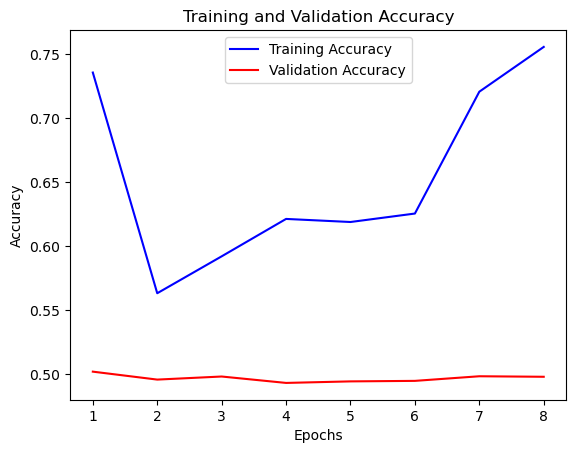

In [58]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

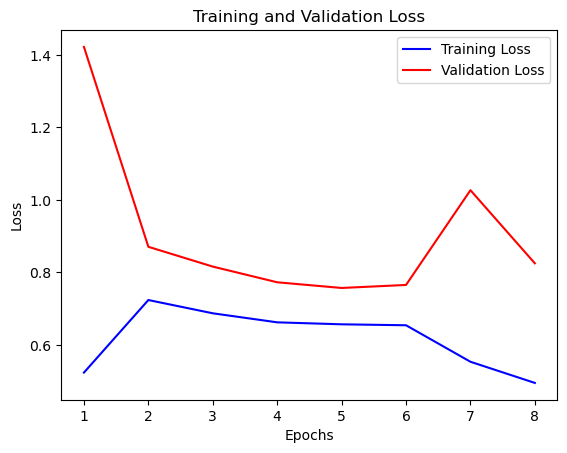

In [59]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [60]:
# num_words=20000,max_len=150, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=256)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
79/79 [==============================] - 51s 643ms/step - loss: 0.4958 - accuracy: 0.7641 - val_loss: 0.6981 - val_accuracy: 0.4984
Epoch 2/10
79/79 [==============================] - 59s 752ms/step - loss: 0.2586 - accuracy: 0.8949 - val_loss: 0.7459 - val_accuracy: 0.5016
Epoch 3/10
79/79 [==============================] - 62s 780ms/step - loss: 0.1772 - accuracy: 0.9332 - val_loss: 0.9537 - val_accuracy: 0.5054
Epoch 4/10
79/79 [==============================] - 61s 779ms/step - loss: 0.1210 - accuracy: 0.9553 - val_loss: 1.3189 - val_accuracy: 0.4946
Epoch 5/10
79/79 [==============================] - 61s 777ms/step - loss: 0.0712 - accuracy: 0.9760 - val_loss: 1.8559 - val_accuracy: 0.4986
Epoch 6/10
79/79 [==============================] - 61s 778ms/step - loss: 0.1509 - accuracy: 0.9408 - val_loss: 1.7836 - val_accuracy: 0.4966
Epoch 7/10
79/79 [==============================] - 61s 777ms/step - loss: 0.0627 - accuracy: 0.9773 - val_loss: 3.0191 - val_accuracy: 0.4914

2023-11-10 04:18:59.531265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:18:59.536348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:18:59.733471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,768]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_True/assets
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 768)          15360000  
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_11  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                 

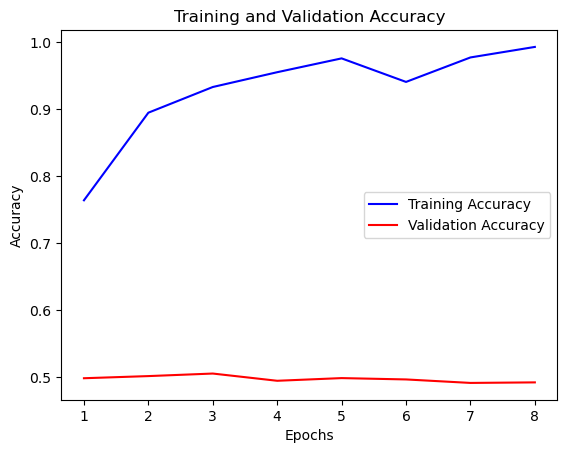

In [61]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

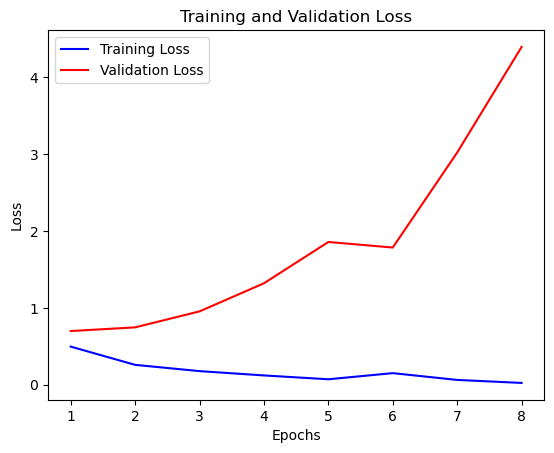

In [62]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [63]:
# num_words=20000,max_len=200, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,200,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=128)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
157/157 [==============================] - 87s 550ms/step - loss: 0.4239 - accuracy: 0.7991 - val_loss: 0.7238 - val_accuracy: 0.4930
Epoch 2/10
157/157 [==============================] - 96s 612ms/step - loss: 0.3252 - accuracy: 0.8569 - val_loss: 0.8135 - val_accuracy: 0.5020
Epoch 3/10
157/157 [==============================] - 95s 604ms/step - loss: 0.1738 - accuracy: 0.9338 - val_loss: 1.3233 - val_accuracy: 0.4984
Epoch 4/10
157/157 [==============================] - 95s 603ms/step - loss: 0.1153 - accuracy: 0.9577 - val_loss: 2.3118 - val_accuracy: 0.4942
Epoch 5/10
157/157 [==============================] - 95s 607ms/step - loss: 0.0831 - accuracy: 0.9700 - val_loss: 3.4900 - val_accuracy: 0.5004
Epoch 6/10
157/157 [==============================] - 90s 571ms/step - loss: 0.0670 - accuracy: 0.9753 - val_loss: 4.2428 - val_accuracy: 0.4974
Epoch 7/10
157/157 [==============================] - 97s 615ms/step - loss: 0.0577 - accuracy: 0.9797 - val_loss: 4.7639 - val_ac

2023-11-10 04:34:54.351929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:34:54.361549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:34:54.630128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,768]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_False/assets
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 768)          15360000  
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 200, 384)          442752    
                                                                 
 global_average_pooling1d_12  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                

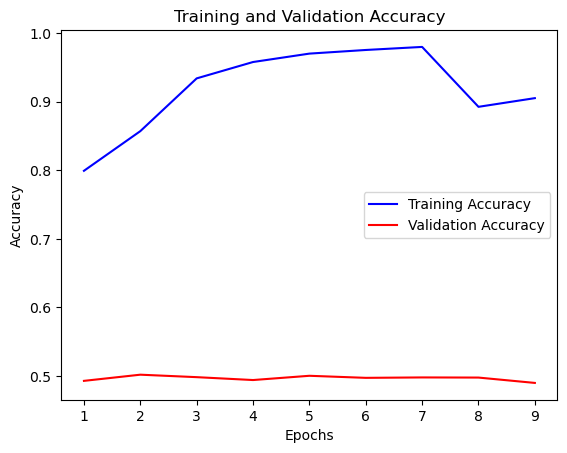

In [64]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

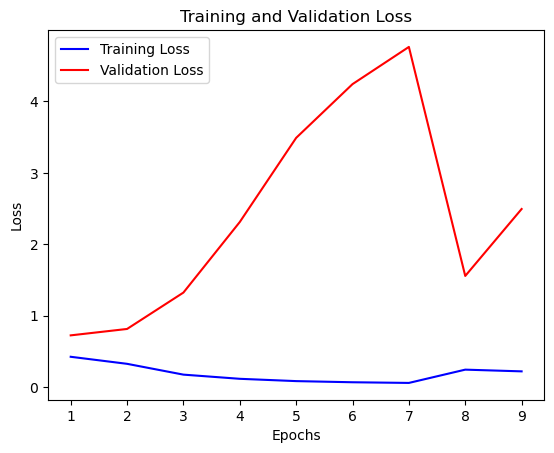

In [65]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [66]:
# num_words=20000,max_len=200, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,200,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=128)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
157/157 [==============================] - 115s 729ms/step - loss: 0.7310 - accuracy: 0.5781 - val_loss: 0.8786 - val_accuracy: 0.4950
Epoch 2/10
157/157 [==============================] - 108s 689ms/step - loss: 0.4908 - accuracy: 0.7782 - val_loss: 1.7122 - val_accuracy: 0.4960
Epoch 3/10
157/157 [==============================] - 110s 703ms/step - loss: 0.2934 - accuracy: 0.8820 - val_loss: 1.5783 - val_accuracy: 0.5022
Epoch 4/10
157/157 [==============================] - 111s 707ms/step - loss: 0.3168 - accuracy: 0.8685 - val_loss: 1.4169 - val_accuracy: 0.5014
Epoch 5/10
157/157 [==============================] - 109s 698ms/step - loss: 0.1765 - accuracy: 0.9327 - val_loss: 2.5111 - val_accuracy: 0.5006
Epoch 6/10
157/157 [==============================] - 111s 706ms/step - loss: 0.1424 - accuracy: 0.9474 - val_loss: 2.9913 - val_accuracy: 0.4992
Epoch 7/10
157/157 [==============================] - 110s 701ms/step - loss: 0.1712 - accuracy: 0.9388 - val_loss: 2.5572 -

2023-11-10 04:53:17.173089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:53:17.182307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,768]
	 [[{{node inputs}}]]
2023-11-10 04:53:17.372358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,768]
	 [[{{node inputs}}]]
2023-11-

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_True/assets
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 768)          15360000  
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 200, 384)          442752    
                                                                 
 global_average_pooling1d_13  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_26 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_13 (Bat  (None, 128)              512       
 chNormalization)                                                
                 

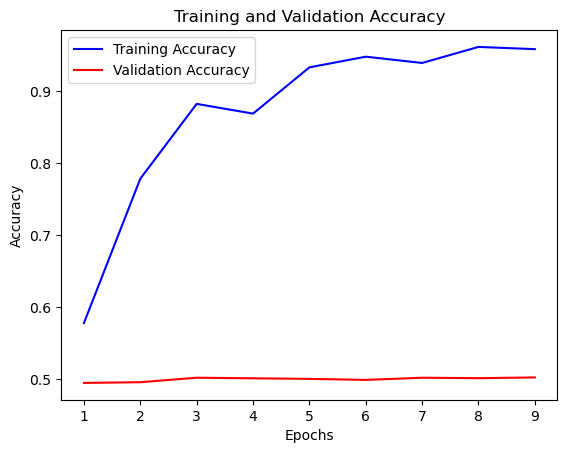

In [67]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

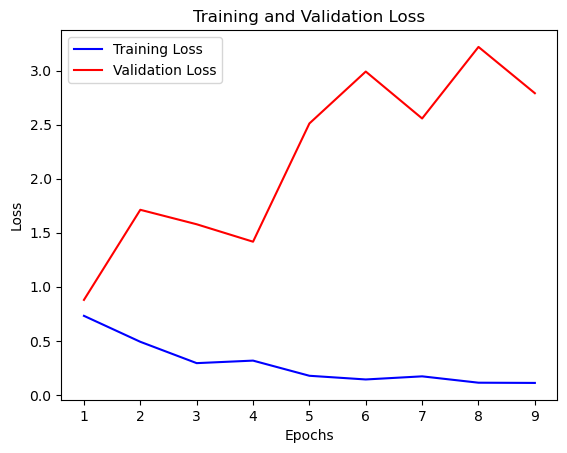

In [68]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Best Accuracy : 0.83188